# Gathering the Dataset

In [1]:
import pandas as pd
from fastai.vision.all import *
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Define the base path
path = Path("data")

In [3]:
# Read CSV files
train_features = pd.read_csv("train_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

In [4]:
# Ensure the label is the one with the maximum value for each row
train_features['label'] = train_labels.idxmax(axis=1)
train_features.head()

,filepath,site,label
id,,,
ZJ000000,train_features/ZJ000000.jpg,S0120,bird
ZJ000001,train_features/ZJ000001.jpg,S0069,monkey_prosimian
ZJ000002,train_features/ZJ000002.jpg,S0009,bird
ZJ000003,train_features/ZJ000003.jpg,S0008,monkey_prosimian
ZJ000004,train_features/ZJ000004.jpg,S0036,leopard


# Build The Model

In [5]:
# Create DataBlock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('filepath', pref=path),
                   get_y=ColReader('label'),
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=Resize(256),
                   batch_tfms=[FlipItem(), Normalize.from_stats(*imagenet_stats)])

In [6]:
# Create DataLoaders
dls = dblock.dataloaders(train_features, bs=64, num_workers=8)

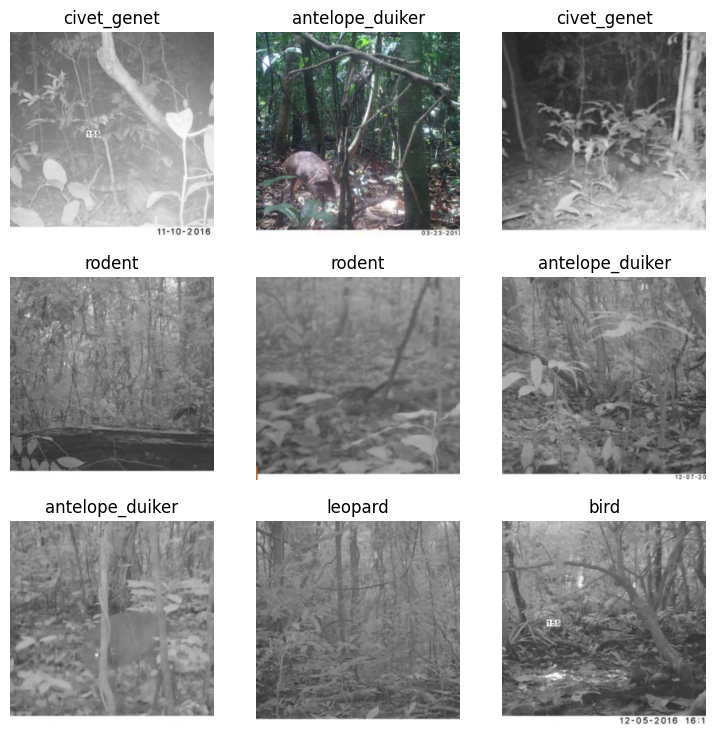

In [7]:
dls.show_batch()

In [8]:
# Calculate the number of items in the training and validation sets
num_train_items = len(dls.train_ds)
num_valid_items = len(dls.valid_ds)

In [9]:
# Print the split ratio
train_ratio = len(dls.train_ds) / (len(dls.train_ds) + len(dls.valid_ds))
valid_ratio = len(dls.valid_ds) / (len(dls.train_ds) + len(dls.valid_ds))
print(f"Train split ratio: {train_ratio:.2f}, Valid split ratio: {valid_ratio:.2f}")

Train split ratio: 0.80, Valid split ratio: 0.20


In [10]:
# Print the sizes of the training and validation DataFrames
print(f"Number of items in training set: {num_train_items}")
print(f"Number of items in validation set: {num_valid_items}")

Number of items in training set: 13191
Number of items in validation set: 3297


In [11]:
# Get a batch of data from the DataLoader
x, y = dls.one_batch()

# Print the shape of the input and target tensors
print("Input shape:", x.shape)
print("Target shape:", y.shape)
# Verify the labels to check they are correctly processed
print("Target values (first batch):", y)

Input shape: torch.Size([64, 3, 256, 256])
Target shape: torch.Size([64])
Target values (first batch): TensorCategory([5, 6, 6, 3, 0, 0, 7, 6, 6, 2, 0, 0, 0, 2, 0, 1, 7, 2, 7, 7, 6,
                0, 0, 2, 1, 0, 1, 4, 2, 7, 3, 0, 3, 3, 3, 6, 0, 0, 6, 3, 2, 0,
                5, 2, 3, 5, 4, 4, 5, 7, 0, 0, 6, 2, 0, 2, 3, 0, 5, 2, 2, 0, 0,
                5], device='cuda:0')


In [12]:
# Create learner
# Train DenseNet121 model
learn_densenet = vision_learner(dls, models.densenet121, metrics=[accuracy, error_rate], pretrained=True)

In [13]:
learn_densenet.summary()

Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 64   
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 128 x 64 x 64  
Conv2d                                    8192       False     
BatchNorm2d                               256        True      
ReLU                                                           
___________________________________

In [14]:
learn_densenet.unfreeze()

SuggestedLRs(valley=0.0003311311302240938)

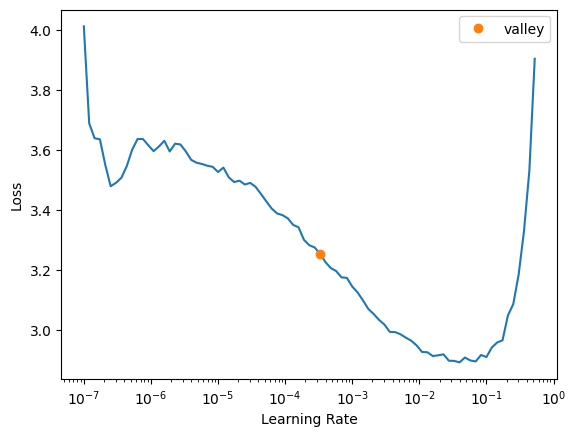

In [15]:
# Find the optimal learning rate
learn_densenet.lr_find()

In [16]:
# Fit the model over 2 epochs
learn_densenet.fine_tune(10, base_lr=4e-03, wd=1e-05)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.521374,1.031911,0.632393,0.367607,02:16


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.981293,0.736660,0.736124,0.263876,02:48
1,0.815546,0.647864,0.763421,0.236579,02:48
2,0.691584,0.616387,0.794662,0.205338,02:48
3,0.588279,0.537796,0.813163,0.186837,02:48
4,0.480419,0.502851,0.831362,0.168638,02:48
5,0.387951,0.474370,0.845921,0.154079,02:48
6,0.279629,0.437225,0.865029,0.134971,02:48
7,0.209212,0.413508,0.877161,0.122839,02:48
8,0.173443,0.406810,0.882014,0.117986,02:48
9,0.150318,0.408483,0.884137,0.115863,02:48


In [17]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model made the worse predictions:
interp = ClassificationInterpretation.from_learner(learn_densenet)

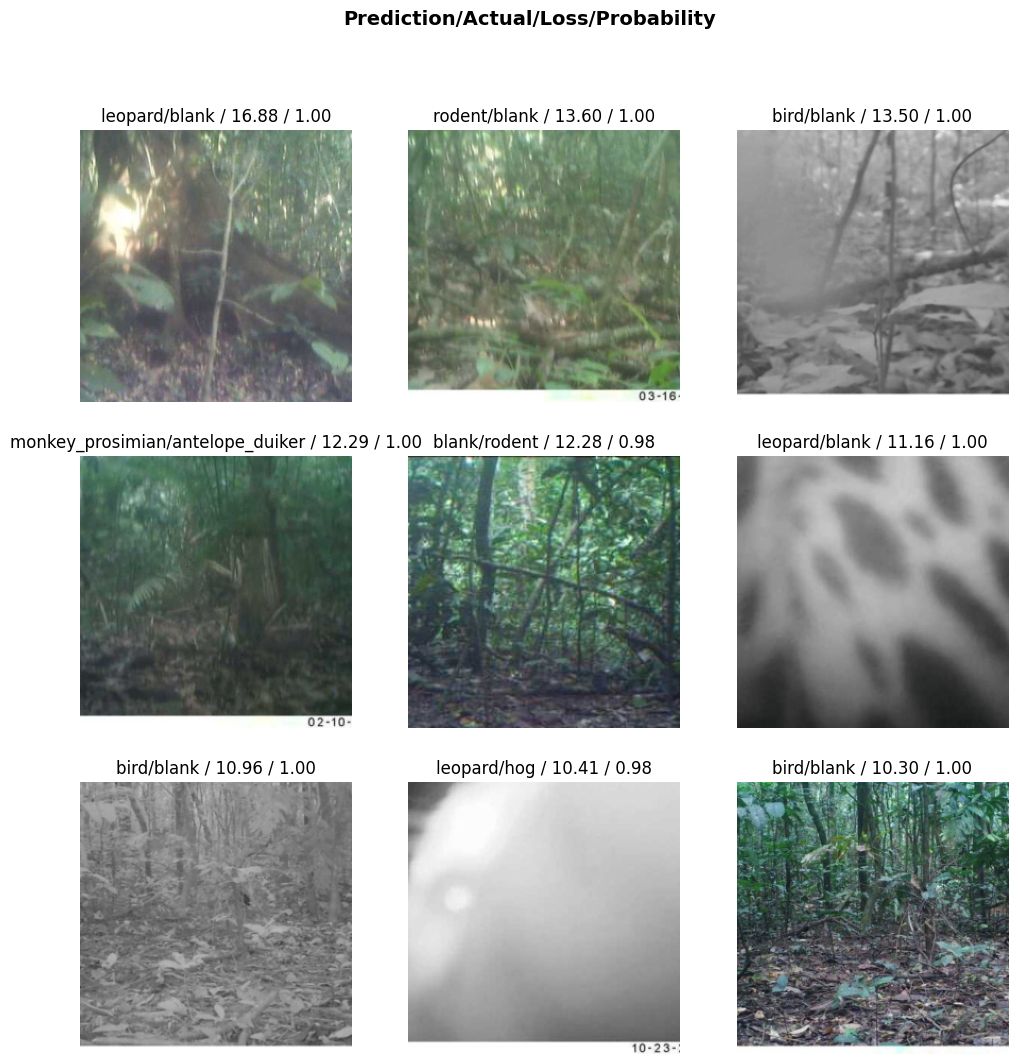

In [18]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(9, figsize=(12,12))

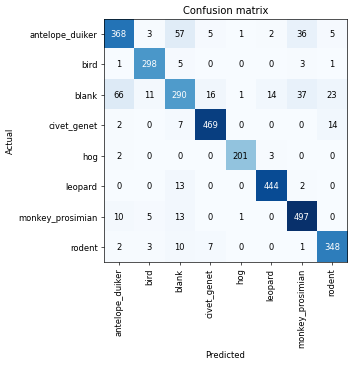

In [19]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [20]:
# Train ResNet50 model
learn_resnet = vision_learner(dls, models.resnet50, metrics=[accuracy, error_rate], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


In [21]:
learn_resnet.summary()

Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 64 x 64  
Conv2d                                    16384      False     
BatchNorm2d                        

In [22]:
learn_resnet.fine_tune(10, base_lr=4e-03, wd=1e-05)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.637582,1.203998,0.577798,0.422202,01:57


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.046610,0.759091,0.735214,0.264786,02:33
1,0.849935,0.660671,0.769184,0.230816,02:33
2,0.717459,0.628037,0.783136,0.216864,02:33
3,0.594061,0.548364,0.818623,0.181377,02:33
4,0.489436,0.523306,0.823779,0.176221,02:33
5,0.399310,0.500439,0.853200,0.146800,02:33
6,0.303630,0.447034,0.866242,0.133758,02:33
7,0.235159,0.449571,0.874128,0.125872,02:33
8,0.181494,0.456808,0.876554,0.123446,02:33
9,0.171805,0.479237,0.880194,0.119806,02:33


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [23]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model made the worse predictions:
interp = ClassificationInterpretation.from_learner(learn_resnet)

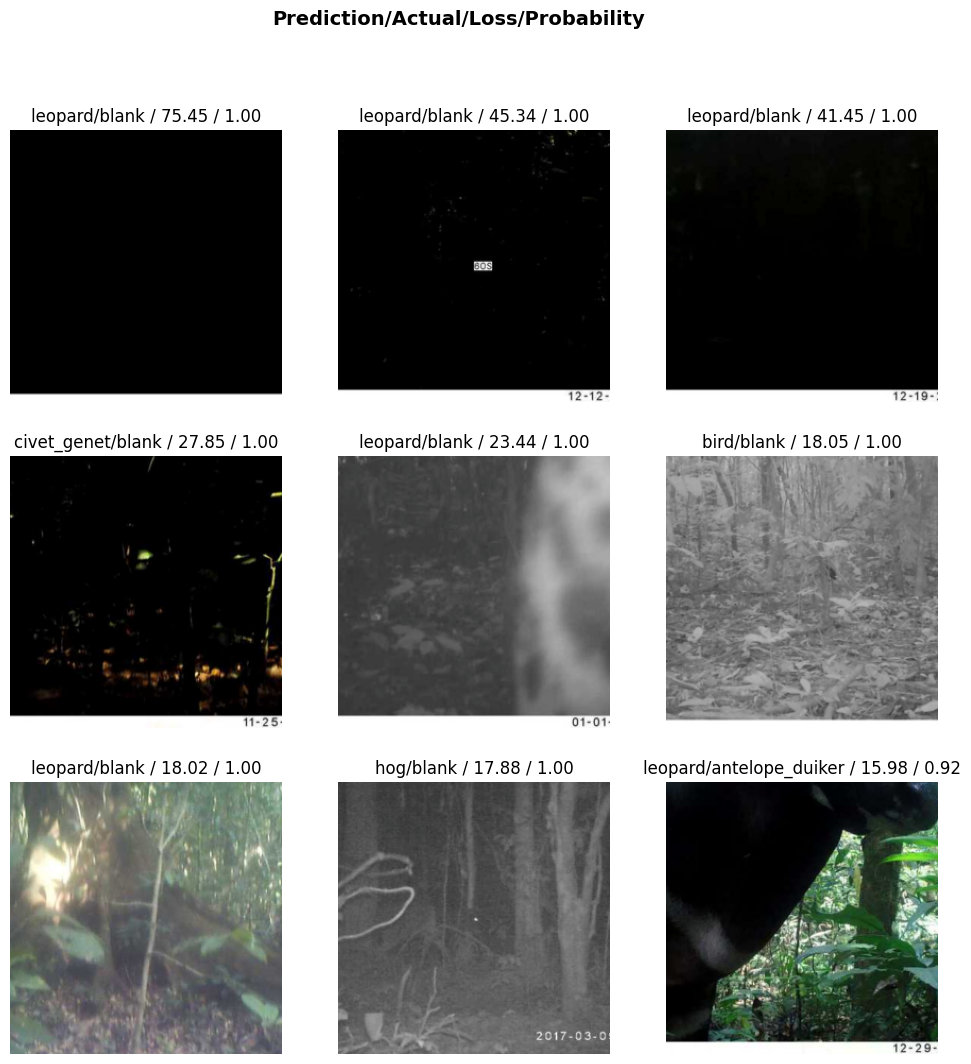

In [24]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(9, figsize=(12,12))

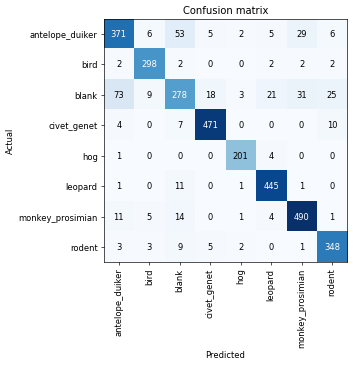

In [25]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

# Ensembling Results using Logistic Regression

In [26]:
# Get predictions from both models
preds_resnet, targs = learn_resnet.get_preds(dl=dls.valid)
preds_densenet, _ = learn_densenet.get_preds(dl=dls.valid)

In [27]:
# Combine predictions (average)
avg_preds = (preds_resnet.numpy() + preds_densenet.numpy()) / 2

In [29]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels
le = LabelEncoder()
encoded_targets = le.fit_transform(targs.numpy())

In [30]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Train Logistic Regression on averaged predictions
clf = LogisticRegression(max_iter=1000)
clf.fit(avg_preds, encoded_targets)

LogisticRegression(max_iter=1000)

In [31]:
# Decode labels
original_labels = le.inverse_transform(range(len(clf.classes_)))

In [32]:
# Get predictions from logistic regression model
pred_probs = clf.predict_proba(avg_preds)

In [33]:
# Print probabilities for each class
for class_idx, class_name in enumerate(original_labels):
    prob = pred_probs[:, class_idx].mean()  # Taking the mean probability across all samples
    print(f"Probability for class '{class_name}': {prob:.4f}")

Probability for class '0': 0.1447
Probability for class '1': 0.0934
Probability for class '2': 0.1389
Probability for class '3': 0.1493
Probability for class '4': 0.0625
Probability for class '5': 0.1392
Probability for class '6': 0.1595
Probability for class '7': 0.1125


In [34]:
# Calculate log loss
logloss = log_loss(encoded_targets, pred_probs)
print("Log Loss:", logloss)

Log Loss: 0.349719992966352


In [35]:
# Save the models and logistic regression
with open("densenet121.pkl", "wb") as f:
    torch.save(learn_densenet, f)

with open("resnet50.pkl", "wb") as f:
    torch.save(learn_resnet, f)

with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(clf, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Streamlit App for User Interface

In [45]:
!pip install streamlit

In [49]:
# Install Streamlit and ipywidgets
!pip install streamlit ipywidgets

In [1]:

# Import the required libraries
from ipywidgets import interactive
import streamlit as st
import numpy as np
import pickle
from PIL import Image as PILImage

# Load saved models and label encoder
def load_models():
    with open('densenet121.pkl', 'rb') as f:
        learn_densenet = pickle.load(f)
    with open('resnet50.pkl', 'rb') as f:
        learn_resnet = pickle.load(f)
    with open('logistic_regression_model.pkl', 'rb') as f:
        clf = pickle.load(f)
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    return learn_densenet, learn_resnet, clf, le

# Predict label and probabilities
def predict_label_and_probs(learn_densenet, learn_resnet, clf, le, img_path):
    # Load the image
    img = PILImage.open(img_path)
    
    # Get predictions from both models
    pred_resnet = learn_resnet.predict(img)[2].numpy()
    pred_densenet = learn_densenet.predict(img)[2].numpy()

    # Combine predictions by averaging
    avg_pred = (pred_resnet + pred_densenet) / 2

    # Get ensemble prediction
    pred_probs = clf.predict_proba(avg_pred.reshape(1, -1))[0]
    pred_class_idx = np.argmax(pred_probs)
    pred_class = le.inverse_transform([pred_class_idx])[0]
    
    return pred_class, pred_probs

# Define your Streamlit app function
def run_streamlit_app():
    # Streamlit app code
    st.title('Hybrid Image Classification')
    
    # Load models
    learn_densenet, learn_resnet, clf, le = load_models()

    # File uploader
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

    if uploaded_file is not None:
        # Display the uploaded image
        img = PILImage.open(uploaded_file)
        st.image(img, caption='Uploaded Image.', use_column_width=True)

        # Predict label and probabilities
        pred_class, pred_probs = predict_label_and_probs(learn_densenet, learn_resnet, clf, le, uploaded_file)

        # Display the predicted label and probabilities
        st.write(f'Predicted Class: {pred_class}')
        st.write('Prediction Probabilities:')
        for i, prob in enumerate(pred_probs):
            st.write(f'{le.inverse_transform([i])[0]}: {prob:.4f}')

In [2]:
# Run the Streamlit app using the %streamlit magic command
%streamlit run run_streamlit_app

UsageError: Line magic function `%streamlit` not found.
